In [1]:
# Import libraries 

import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random

In [2]:
import requests
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import config

In [3]:
# Initialize SpotiPy with user credentias

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=config.client_id,
                                                           client_secret=config.client_secret))

### User Interaction Flow

In [4]:
# Read dataframe with web scraped top 100 songs. These songs are "hot" 

df = pd.read_csv("artist_song_list.csv")

In [5]:
# Define a wrapper to get a track id from Spotify with "sp.search"

def get_track_id(track): 
    search_track = sp.search(q=track, type='track')
    track_id = search_track['tracks']['items'][0]['id']
    return track_id

In [6]:
get_track_id("war in my mind")

'0D123zNFzYdUfmKo8n1ccY'

In [7]:
# Get information about a track: name, album. artist

def get_track_data(track_id):
    meta = sp.track(track_id)
    track_details = {"name":meta['name'], "album":meta['album']['name'], 
                    "artist":meta['album']['artists'][0]['name']}
    return track_details

In [8]:
get_track_data('0D123zNFzYdUfmKo8n1ccY')

{'name': 'War In My Mind', 'album': 'War In My Mind', 'artist': 'Beth Hart'}

In [9]:
# Define song recommendation function. 
# If the user input song is in the list of top 100 song, she/he gets another song from the top 100 list. If not it returns, "it´s not hot"

def recommend_song():
    requested_song = input("Tell me your favorite song: ")
        
    if requested_song in list(df["song"]):
        choice = df["song"].iloc[random.randint(0,len(df))]
        return "Excellent choice! You will also like the song"  + " " + choice
    else:
        song_id = get_track_id(requested_song)
        print(song_id)
        print(requested_song)
        song_data = get_track_data(song_id)
        print(song_data)
        return "This song is not hot. But your song is really good: " + song_data['name'] + " by " + song_data['artist']

In [10]:
recommend_song()

Tell me your favorite song: bad guy
2Fxmhks0bxGSBdJ92vM42m
bad guy
{'name': 'bad guy', 'album': 'WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?', 'artist': 'Billie Eilish'}


'This song is not hot. But your song is really good: bad guy by Billie Eilish'

### Scaling Audio Features for Clustering 

In [13]:
# Read file with collection of songs and audio features 

song_lst = pd.read_pickle("100kfeatslist.pkl")
song_lst = [song for song in song_lst if song]
df_101k_songs = pd.DataFrame(song_lst)

In [14]:
# Check the dataframe columns and its content. 
#(The track id (column="id") is given, but not the track name or artist)

df_101k_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.1170,0.1080,10,-26.922,1,0.0514,0.471,0.942,0.0785,0.0533,168.900,audio_features,0saVGOHWPnGXus321u3c1i,spotify:track:0saVGOHWPnGXus321u3c1i,https://api.spotify.com/v1/tracks/0saVGOHWPnGX...,https://api.spotify.com/v1/audio-analysis/0saV...,236347,4
1,0.0663,0.0906,2,-26.770,0,0.0457,0.810,0.645,0.1120,0.0427,57.020,audio_features,0tQjYkNljPf8hhP7RdseSb,spotify:track:0tQjYkNljPf8hhP7RdseSb,https://api.spotify.com/v1/tracks/0tQjYkNljPf8...,https://api.spotify.com/v1/audio-analysis/0tQj...,121627,4
2,0.3990,0.2190,10,-22.531,0,0.0351,0.911,0.910,0.0915,0.1270,139.034,audio_features,78U33gGujgyj1393Dr8uWO,spotify:track:78U33gGujgyj1393Dr8uWO,https://api.spotify.com/v1/tracks/78U33gGujgyj...,https://api.spotify.com/v1/audio-analysis/78U3...,178653,4
3,0.2390,0.0358,2,-24.548,0,0.0414,0.962,0.923,0.0841,0.0529,116.784,audio_features,7MqzOAWxhXEoRyivx1cfdF,spotify:track:7MqzOAWxhXEoRyivx1cfdF,https://api.spotify.com/v1/tracks/7MqzOAWxhXEo...,https://api.spotify.com/v1/audio-analysis/7Mqz...,143040,4
4,0.0937,0.0496,8,-25.550,1,0.0401,0.930,0.883,0.0560,0.0319,79.851,audio_features,7LlnIsRxZD5w2GmGD1u3l1,spotify:track:7LlnIsRxZD5w2GmGD1u3l1,https://api.spotify.com/v1/tracks/7LlnIsRxZD5w...,https://api.spotify.com/v1/audio-analysis/7Lln...,374200,4


In [15]:
# Create dataframe with audio feature columns only, as only these values are needed for the clustering 

df_acoustic_features = pd.DataFrame(data=df_101k_songs, columns=["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"])
df_acoustic_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.1170,0.1080,10,-26.922,1,0.0514,0.4710,0.942000,0.0785,0.0533,168.900
1,0.0663,0.0906,2,-26.770,0,0.0457,0.8100,0.645000,0.1120,0.0427,57.020
2,0.3990,0.2190,10,-22.531,0,0.0351,0.9110,0.910000,0.0915,0.1270,139.034
3,0.2390,0.0358,2,-24.548,0,0.0414,0.9620,0.923000,0.0841,0.0529,116.784
4,0.0937,0.0496,8,-25.550,1,0.0401,0.9300,0.883000,0.0560,0.0319,79.851
...,...,...,...,...,...,...,...,...,...,...,...
101381,0.7910,0.6080,6,-10.428,0,0.2880,0.0556,0.000074,0.3610,0.6210,111.518
101382,0.7890,0.4270,11,-12.633,1,0.1390,0.1340,0.883000,0.2880,0.8710,96.885
101383,0.6020,0.7980,4,-10.125,0,0.0703,0.0159,0.407000,0.3760,0.5040,197.143
101384,0.9200,0.6460,1,-8.735,1,0.2850,0.0430,0.000012,0.3070,0.8310,93.794


We see that the scales of the variables differ, e.g. the scale of "tempo" is bigger than of "valence". 

K-Means is a distance based algorithm.

The scales need to be normalized.

In [16]:
scaler = StandardScaler()
scaler.fit(df_acoustic_features)
df_acoustic_features_scaled = scaler.transform(df_acoustic_features)
acoustic_features_scaled_df = pd.DataFrame(df_acoustic_features_scaled, columns = df_acoustic_features.columns)
display(df_acoustic_features.head())
print()
display(acoustic_features_scaled_df.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.1170,0.1080,10,-26.922,1,0.0514,0.471,0.942,0.0785,0.0533,168.900
1,0.0663,0.0906,2,-26.770,0,0.0457,0.810,0.645,0.1120,0.0427,57.020
2,0.3990,0.2190,10,-22.531,0,0.0351,0.911,0.910,0.0915,0.1270,139.034
3,0.2390,0.0358,2,-24.548,0,0.0414,0.962,0.923,0.0841,0.0529,116.784
4,0.0937,0.0496,8,-25.550,1,0.0401,0.930,0.883,0.0560,0.0319,79.851


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,-2.512843,-2.006280,1.332823,-3.367687,0.704451,-0.313930,0.527440,2.731378,-0.694355,-1.720542,1.642484
1,-2.796854,-2.076035,-0.907348,-3.338833,-1.419545,-0.370596,1.572196,1.718088,-0.490190,-1.761196,-2.150826
2,-0.933137,-1.561294,1.332823,-2.534144,-1.419545,-0.475976,1.883465,2.622202,-0.615127,-1.437883,0.629872
3,-1.829424,-2.295722,-0.907348,-2.917031,-1.419545,-0.413345,2.040641,2.666555,-0.660226,-1.722076,-0.124518
4,-2.643365,-2.240399,0.772781,-3.107241,0.704451,-0.426269,1.942021,2.530085,-0.831480,-1.802617,-1.376737


### Clustering with K-Means

In [ ]:
# The number of cluster is manually set to 40. The song collection is huge and there should be a lot of different music genres
# K-means picks randomly the initial centroids
# Random seed is being used in order to reproduce te results. It is set in random_state

In [17]:
kmeans = KMeans(n_clusters=40, random_state=1233)
kmeans.fit(acoustic_features_scaled_df)

KMeans(n_clusters=40, random_state=1233)

In [18]:
kmeans.labels_

array([25, 21, 21, ..., 14, 32, 33])

In [19]:
# See the clusters and how many observations each cluster has. 
# The distribution is okay - besides cluster nr.23, it is way smaller than the other clusters 

clusters = kmeans.predict(acoustic_features_scaled_df)
pd.Series(clusters).value_counts().sort_index()

0     2644
1     3462
2     2033
3     3866
4     1507
5     1665
6     2469
7     3689
8     3896
9     2378
10    2977
11    1861
12    1522
13    2923
14    2685
15    2210
16    2361
17    3502
18    2786
19    2333
20    1685
21    1506
22    5280
23     615
24    2233
25    1183
26    3277
27    2632
28    2107
29    3207
30    2863
31    1057
32    2142
33    1920
34    4327
35    1769
36    2020
37    1970
38    3344
39    3480
dtype: int64

In [20]:
# Add the cluster number for each track/row as additionl column to dataframe 

df_acoustic_features["cluster"] = clusters
df_acoustic_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.1170,0.1080,10,-26.922,1,0.0514,0.471,0.942,0.0785,0.0533,168.900,25
1,0.0663,0.0906,2,-26.770,0,0.0457,0.810,0.645,0.1120,0.0427,57.020,21
2,0.3990,0.2190,10,-22.531,0,0.0351,0.911,0.910,0.0915,0.1270,139.034,21
3,0.2390,0.0358,2,-24.548,0,0.0414,0.962,0.923,0.0841,0.0529,116.784,21
4,0.0937,0.0496,8,-25.550,1,0.0401,0.930,0.883,0.0560,0.0319,79.851,2


In [21]:
# Add the track id for each track/row as additionl column to dataframe 

df_acoustic_features["id"] = df_101k_songs["id"]
df_acoustic_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster,id
0,0.1170,0.1080,10,-26.922,1,0.0514,0.4710,0.942000,0.0785,0.0533,168.900,25,0saVGOHWPnGXus321u3c1i
1,0.0663,0.0906,2,-26.770,0,0.0457,0.8100,0.645000,0.1120,0.0427,57.020,21,0tQjYkNljPf8hhP7RdseSb
2,0.3990,0.2190,10,-22.531,0,0.0351,0.9110,0.910000,0.0915,0.1270,139.034,21,78U33gGujgyj1393Dr8uWO
3,0.2390,0.0358,2,-24.548,0,0.0414,0.9620,0.923000,0.0841,0.0529,116.784,21,7MqzOAWxhXEoRyivx1cfdF
4,0.0937,0.0496,8,-25.550,1,0.0401,0.9300,0.883000,0.0560,0.0319,79.851,2,7LlnIsRxZD5w2GmGD1u3l1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101381,0.7910,0.6080,6,-10.428,0,0.2880,0.0556,0.000074,0.3610,0.6210,111.518,33,6tYX8lbMl5aH3p3Cnew6mG
101382,0.7890,0.4270,11,-12.633,1,0.1390,0.1340,0.883000,0.2880,0.8710,96.885,19,0wkaBWFqLAvhnLosIsgSp1
101383,0.6020,0.7980,4,-10.125,0,0.0703,0.0159,0.407000,0.3760,0.5040,197.143,14,1X2O4ObuDdTZAsAVB6zg5t
101384,0.9200,0.6460,1,-8.735,1,0.2850,0.0430,0.000012,0.3070,0.8310,93.794,32,6zceR6vUKRuEwVYEODIhz2


In [22]:
# Save the dataframe with the cluster and id columns

df_acoustic_features.to_csv("df_acoustic_features.csv")

In [23]:
# New dataframe, with only the columns that are needed for user interaction 

lookup_cluster_id_df = pd.DataFrame(data=df_acoustic_features, columns=["cluster", "id"])
lookup_cluster_id_df

,cluster,id
0,25,0saVGOHWPnGXus321u3c1i
1,21,0tQjYkNljPf8hhP7RdseSb
2,21,78U33gGujgyj1393Dr8uWO
3,21,7MqzOAWxhXEoRyivx1cfdF
4,2,7LlnIsRxZD5w2GmGD1u3l1
...,...,...
101381,33,6tYX8lbMl5aH3p3Cnew6mG
101382,19,0wkaBWFqLAvhnLosIsgSp1
101383,14,1X2O4ObuDdTZAsAVB6zg5t
101384,32,6zceR6vUKRuEwVYEODIhz2


### Saving with Pickle and reloading Scaler and Cluster

In [25]:
import pickle

# Saving the:
#scaler = StandardScaler()
#model = KMeans()

with open("Model/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

with open("Model/kmeans.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [26]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
    except FileNotFoundError: 
        print("File not found!")

In [45]:
scaler_2 = load("Model/scaler.pickle")
scaler_2

StandardScaler()

In [46]:
kmeans_2 = load("Model/kmeans.pickle")
kmeans_2

KMeans(n_clusters=40, random_state=1233)

### Getting User Input

In [47]:
def get_track_data(track_id):
    meta = sp.track(track_id)
    track_details = {"name":meta['name'], "album":meta['album']['name'], 
                    "artist":meta['album']['artists'][0]['name']}
    return track_details

In [48]:
# The user is providing the track´s id

get_track_data("1i3fTnSg2X03MWLEt411Eb")

{'name': "when the party's over",
 'album': 'ESTATE 2021 HITS',
 'artist': 'Various Artists'}

In [49]:
# Get information about the track on Spotify

results = sp.search(q="uri:1i3fTnSg2X03MWLEt411Eb")
results

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=uri%3A1i3fTnSg2X03MWLEt411Eb&type=track&offset=0&limit=10',
  'items': [],
  'limit': 10,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0}}

### Computing User Input

In [50]:
# Show audio features for the track id, the user gave as input

user_choice=pd.DataFrame(data=sp.audio_features("spotify:track:7yu8AMzJIp4HHBXEnP2u6Z"),columns=["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo"])
user_choice

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.379,0.279,2,-11.842,0,0.0429,0.651,0.0595,0.0823,0.139,150.761


In [51]:
# Scale the audio features of the track
# Save scaled input as dataframe 

def scale_user_choice(user_choice):
    scaler_2.fit(user_choice)
    user_choice_scaled = scaler.transform(user_choice)
    user_choice_scaled_df = pd.DataFrame(user_choice_scaled, columns = user_choice.columns)
    return user_choice_scaled_df

In [52]:
user_choice_scaled_df = scale_user_choice(user_choice)

In [53]:
# Use the trained K-means model to predict the cluster, the input track belongs to

def get_choice_cluster(user_choice_scaled_df):
    user_cluster = kmeans_2.predict(user_choice_scaled_df)
    return user_cluster

In [54]:
user_choice_cluster = get_choice_cluster(user_choice_scaled_df)

In [55]:
# Which cluster does the user input song belongs to

user_choice_cluster

array([9])

In [56]:
# Randomly choose another song from the same cluster

def check_cluster(user_choice_cluster):
    recommended_song_id = lookup_cluster_id_df[lookup_cluster_id_df["cluster"]==user_choice_cluster[0]]["id"].sample().iloc[-1]
    return recommended_song_id

In [57]:
recommended_song_id = check_cluster(user_choice_cluster)
recommended_song_id

'1gje54FR9j2CsCmtuG8dkF'

In [66]:
# Return the randomly choosen song as a recommendation for the user

def final_recommendation(recommended_song_id):
    recommended_song_from_cluster = get_track_data(recommended_song_id)["name"]
    artist_of_recommended_song_from_cluster = get_track_data(recommended_song_id)["artist"]
    album_of_recommended_song_from_cluster = get_track_data(recommended_song_id)["album"]
    print("You may also like the song"+ " " + recommended_song_from_cluster + " by " + 
      artist_of_recommended_song_from_cluster + ". Listen to it here: https://open.spotify.com/track/" + recommended_song_id)

In [67]:
final_recommendation(recommended_song_id)

You may also like the song Land Of A Thousand Boys by Brenda Holloway. Listen to it here: https://open.spotify.com/track/1gje54FR9j2CsCmtuG8dkF


### PROTOTYPE

In [68]:
def recommend_song():
    requested_song = input("Tell me your favorite song: ")
        
    if requested_song in list(df["song"]):
        choice = df["song"].iloc[random.randint(0,len(df))]
        return "Excellent choice! You will also like the song"  + " " + choice
    else:
        song_id = get_track_id(requested_song)
        chosen_song = get_track_data(song_id)
        print("You chose the song " + chosen_song['name'] + " by " + chosen_song['artist'])
        user_choice = pd.DataFrame(data=sp.audio_features(song_id),columns=["danceability",
                                                                            "energy","key",
                                                                            "loudness",
                                                                            "mode","speechiness",
                                                                            "acousticness",
                                                                            "instrumentalness",
                                                                            "liveness","valence",
                                                                            "tempo"])
        user_choice_scaled = scale_user_choice(user_choice)
        user_choice_scaled_cluster = get_choice_cluster(user_choice_scaled)
        recommended_song_id = check_cluster(user_choice_scaled_cluster)

        return final_recommendation(recommended_song_id)

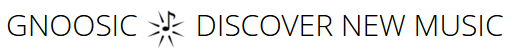

## Welcome to Gnod's World of Music

#### Let us know - What is your favorite song? 

In [105]:
recommend_song()

Tell me your favorite song: hyper hyper
You chose the song Hyper Hyper by Scooter
You may also like the song F**kin' Perfect - Live by P!nk. Listen to it here: https://open.spotify.com/track/5SDxsjvegCAJwfQjFmc4WY
